In [4]:
import pandas as pd
import numpy as np
import glob
import datetime as dt
import pandas_datareader.data as web
import quandl
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score

In [5]:
data_folder = "data"
csvDataFiles = sorted(glob.glob(data_folder + "/*.csv"))
dataFiles = []
for dataFile in csvDataFiles:
    df = pd.read_csv(dataFile)
    dataFiles.append(df)

In [6]:
#The number of stocks we have in our data folder
print(len(dataFiles))

30


In [7]:
#This is what our data looks like
dataFiles[0].head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,10/2/2017,154.259995,154.449997,152.720001,153.809998,152.636734,18698800
1,10/3/2017,154.009995,155.089996,153.910004,154.479996,153.301620,16230300
2,10/4/2017,153.630005,153.860001,152.460007,153.479996,152.309250,20163800
3,10/5/2017,154.179993,155.440002,154.050003,155.389999,154.204681,21283800
4,10/6/2017,154.970001,155.490005,154.559998,155.300003,154.115372,17407600


In [8]:
#This is what the end of the data looks like
#We can see it goes from 10/2/17 - 03/29/18
dataFiles[0].tail()

,Date,Open,High,Low,Close,Adj Close,Volume
119,3/23/2018,168.389999,169.919998,164.940002,164.940002,164.940002,41028800
120,3/26/2018,168.070007,173.100006,166.440002,172.770004,172.770004,37541200
121,3/27/2018,173.679993,175.149994,166.919998,168.339996,168.339996,40922600
122,3/28/2018,167.250000,170.020004,165.190002,166.479996,166.479996,41668500
123,3/29/2018,167.809998,171.750000,166.899994,167.779999,167.779999,38398500


In [9]:
#The dimensions of the stock data -- 124 rows and 7 columns
dataFiles[0].shape

(124, 7)

In [10]:
#Lets store the ratings in a form we can understand
ratings_folder = "Ratings"
xlsxRatingFiles = sorted(glob.glob(ratings_folder + "/*.xlsx"))
ratingsFiles = []
for ratingFile in xlsxRatingFiles:
    rf = pd.ExcelFile(ratingFile)
    ratingsFiles.append(rf.parse())

In [11]:
#The number of ratings files we have in our ratings folder
print(len(ratingsFiles))

30


In [12]:
#This is what our ratings look like
ratingsFiles[0].head()

,0,1,2,3
5,6,6,7,8
4,0,0,0,0
3,5,5,4,3
2,0,0,0,0
1,0,0,0,0


In [13]:
#The dimensions of the ratings data -- 5 rows and 4 columns
ratingsFiles[0].shape

(5, 4)

In [14]:
#Let's now find the stock market returns for each of the last 3 months of our data
#as these are the months that we have ratings for
start3MonthsAgo = dt.datetime(2018, 1, 1)
end2MonthsAgo = dt.datetime(2018, 1, 31)

start2MonthsAgo = dt.datetime(2018, 2, 1)
end1MonthAgo = dt.datetime(2018, 2, 28)

start1MonthAgo = dt.datetime(2018, 3, 1)
end1MonthAgo = dt.datetime(2018, 3, 29)

nasdaqData1MonthAgo = quandl.get("NASDAQOMX/COMP-NASDAQ", trim_start=start1MonthAgo, trim_end=end1MonthAgo)

#Don't execute the next 2 lines until later, otherwise the API will be overloaded and block you
#nasdaqData2MonthsAgo = quandl.get("NASDAQOMX/COMP-NASDAQ", trim_start=end2MonthsAgo, trim_end=end1MonthAgo)
#nasdaqData3MonthsAgo = quandl.get("NASDAQOMX/COMP-NASDAQ", trim_start=start3MonthsAgo, trim_end=end2MonthsAgo)

#Let's see what our data looks like
nasdaqData1MonthAgo.head()

,Index Value,High,Low,Total Market Value,Dividend Market Value
Trade Date,,,,,
2018-03-01,7180.56,7307.84,7117.66,1.096433e+13,1.412534e+09
2018-03-02,7257.87,7267.19,7084.83,1.108254e+13,5.519555e+08
2018-03-05,7330.70,7350.07,7205.31,1.119375e+13,2.423415e+07
2018-03-06,7372.01,7378.03,7319.68,1.125703e+13,1.519576e+08
2018-03-07,7396.65,7403.79,7311.74,1.127635e+13,7.535249e+07


In [15]:
#Lets drop everything but the index value as that's all we will care about
nasdaqData1MonthAgo = nasdaqData1MonthAgo[['Index Value']]
nasdaqData1MonthAgo.head()

,Index Value
Trade Date,
2018-03-01,7180.56
2018-03-02,7257.87
2018-03-05,7330.70
2018-03-06,7372.01
2018-03-07,7396.65


In [16]:
firstDay = 0
initPrice = nasdaqData1MonthAgo.iloc[firstDay]['Index Value']

lastDay = nasdaqData1MonthAgo.shape[0] - 1
finalPrice = nasdaqData1MonthAgo.iloc[lastDay]['Index Value']

#Market growth
oneMonthAgoROI = (finalPrice - initPrice) / initPrice
print(oneMonthAgoROI)

-0.016310705571710396


In [17]:
#Let's do the same thing for the 2 earlier months
nasdaqData2MonthsAgo = quandl.get("NASDAQOMX/COMP-NASDAQ", trim_start=end2MonthsAgo, trim_end=end1MonthAgo)
nasdaqData2MonthsAgo = nasdaqData2MonthsAgo[['Index Value']]

firstDay = 0
initPrice = nasdaqData2MonthsAgo.iloc[firstDay]['Index Value']

lastDay = nasdaqData2MonthsAgo.shape[0] - 1
finalPrice = nasdaqData2MonthsAgo.iloc[lastDay]['Index Value']

#Market growth
twoMonthsAgoROI = (finalPrice - initPrice) / initPrice
print(twoMonthsAgoROI)

-0.04695958162202421


In [18]:
#And for 3rd month ago
nasdaqData3MonthsAgo = quandl.get("NASDAQOMX/COMP-NASDAQ", trim_start=start3MonthsAgo, trim_end=end2MonthsAgo)
nasdaqData23MonthsAgo = nasdaqData3MonthsAgo[['Index Value']]

firstDay = 0
initPrice = nasdaqData3MonthsAgo.iloc[firstDay]['Index Value']

lastDay = nasdaqData3MonthsAgo.shape[0] - 1
finalPrice = nasdaqData3MonthsAgo.iloc[lastDay]['Index Value']

#Market growth
threeMonthsAgoROI = (finalPrice - initPrice) / initPrice
print(threeMonthsAgoROI)

0.057740227490045516


In [19]:
#Let's see how to professionals' ratings for specific stocks compared to the market returns

#The NASDAQ growth looks like this:
#01/01/18 - 01/31/18 : 5.7740227490045516 %
#02/01/18 - 02/28/18 : -4.695958162202421 %
#03/01/18 - 03/29/18 : -1.6310705571710396 %

#We don't need the current rating, so we'll drop it from each of the ratings data frames
#Then, we can calculate the avg rating for one month ago for each stock

avgRating1MonthAgo = []
avgRating2MonthsAgo = []
avgRating3MonthsAgo = []

    #for ratingFile in ratingsFiles:

        #remove current rating
        #del ratingFile[0]

for ratingFile in ratingsFiles:
    avgRating = 0
    xMonthAgo = 1
    totalReviewers = 0

    #Aggreate the ratings for the month
    #ratingFile.iloc[5 - rating][month]
    for index in range(len(ratingFile)):
        rating = 5 - index
        reviewers = ratingFile.iloc[index][xMonthAgo]
        totalReviewers += reviewers
        avgRating += rating * reviewers

        #set reviewers to 0 for next iteration
        reviewers = 0
    avgRating /= float(totalReviewers)
    avgRating1MonthAgo.append(avgRating)

#same thing for the 2nd month ago
for ratingFile in ratingsFiles:
    avgRating = 0
    xMonthAgo = 2
    totalReviewers = 0

    #Aggreate the ratings for the month
    #ratingFile.iloc[5 - rating][month]
    for index in range(len(ratingFile)):
        rating = 5 - index
        reviewers = ratingFile.iloc[index][xMonthAgo]
        totalReviewers += reviewers
        avgRating += rating * reviewers

        #set reviewers to 0 for next iteration
        reviewers = 0
    avgRating /= float(totalReviewers)
    avgRating2MonthsAgo.append(avgRating)

#And again for the 3rd month ago
for ratingFile in ratingsFiles:
    avgRating = 0
    xMonthAgo = 3
    totalReviewers = 0

    #Aggreate the ratings for the month
    #ratingFile.iloc[5 - rating][month]
    for index in range(len(ratingFile)):
        rating = 5 - index
        reviewers = ratingFile.iloc[index][xMonthAgo]
        totalReviewers += reviewers
        avgRating += rating * reviewers

        #set reviewers to 0 for next iteration
        reviewers = 0
    avgRating /= float(totalReviewers)
    avgRating3MonthsAgo.append(avgRating)
    

In [20]:
#Now, let's create a data frame with 2 dimensions: the average ranking at the beginning of the month for each specific stock
#and the sign of the difference of the NASDAQ growth and the stock growth

stockROIsMarch = []
#This is for the month of March
for index in range(len(dataFiles)):
    
    stockROI = 0
    
    firstRowIndex = 103
    openIndex = 1
    March1Open = dataFiles[index].iloc[firstRowIndex][openIndex]

    lastRowIndex = dataFiles[index].shape[0] - 1
    closeIndex = 4
    March29Close = dataFiles[index].iloc[lastRowIndex][closeIndex]
    
    stockROI = (March29Close - March1Open) / March1Open
    stockROIsMarch.append(stockROI)
    
stockROIsFebruary = []
#now for feb
for index in range(len(dataFiles)):
    
    stockROI = 0
    
    firstRowIndex = 84
    openIndex = 1
    Feb1Open = dataFiles[index].iloc[firstRowIndex][openIndex]

    lastRowIndex = 102
    closeIndex = 4
    Feb28Close = dataFiles[index].iloc[lastRowIndex][closeIndex]
    
    stockROI = (Feb28Close - Feb1Open) / Feb1Open
    stockROIsFebruary.append(stockROI)
    
stockROIsJanuary = []
#Now for January -- ** Note, market opens on the 2nd of January, not the 1st
for index in range(len(dataFiles)):
    
    stockROI = 0
    
    firstRowIndex = 63
    openIndex = 1
    Jan2Open = dataFiles[index].iloc[firstRowIndex][openIndex]

    lastRowIndex = 83
    closeIndex = 4
    Jan31Close = dataFiles[index].iloc[lastRowIndex][closeIndex]
    
    stockROI = (Jan31Close - Jan2Open) / Jan2Open
    stockROIsJanuary.append(stockROI)


In [21]:
#Using the stockROIs for each month, let's create 3 data frames--one for each month--that includes:
#the avg rating with a label that's positive if the stock beat the market and negative otherwise

#Subtract NASDAQ returns from stocks
didStockBeatMarket3MonthsAgo = list(stockROIsJanuary)
didStockBeatMarket3MonthsAgo[:] = [stockROI - threeMonthsAgoROI for stockROI in didStockBeatMarket3MonthsAgo]

didStockBeatMarket2MonthsAgo = list(stockROIsFebruary)
didStockBeatMarket2MonthsAgo[:] = [stockROI - twoMonthsAgoROI for stockROI in didStockBeatMarket2MonthsAgo]

didStockBeatMarket1MonthAgo = list(stockROIsMarch)
didStockBeatMarket1MonthAgo[:] = [stockROI - oneMonthAgoROI for stockROI in didStockBeatMarket1MonthAgo]


In [22]:
#Turn ratings' arrays into data frame
ratingsMarch = pd.DataFrame(np.array(avgRating1MonthAgo).reshape(30,1))
ratingsFebruary = pd.DataFrame(np.array(avgRating2MonthsAgo).reshape(30,1))
ratingsJanuary = pd.DataFrame(np.array(avgRating3MonthsAgo).reshape(30,1))

resultsMarch = pd.DataFrame(np.array(didStockBeatMarket1MonthAgo).reshape(30,1))
resultsFebruary = pd.DataFrame(np.array(didStockBeatMarket2MonthsAgo).reshape(30,1))
resultsJanuary = pd.DataFrame(np.array(didStockBeatMarket3MonthsAgo).reshape(30,1))

In [23]:
ratingsMarch.shape

(30, 1)

In [24]:
resultsMarch.shape

(30, 1)

In [25]:
resultsMarch.head()

,0
0,-0.043956
1,-0.030101
2,-0.078768
3,-0.024621
4,-0.023752


In [26]:
#Apply a sign function to the labels
resultsMarch[resultsMarch > 0] = 1
resultsMarch[resultsMarch < 0] = -1
resultsMarch.head()

,0
0,-1.0
1,-1.0
2,-1.0
3,-1.0
4,-1.0


In [27]:
#And again
resultsFebruary[resultsFebruary > 0] = 1
resultsFebruary[resultsFebruary < 0] = -1

resultsJanuary[resultsJanuary > 0] = 1
resultsJanuary[resultsJanuary < 0] = -1


In [28]:
#create the data frame for each month -- include rating and the label indicating whether the stock outperformed market
dfMarch=pd.concat([ratingsMarch, resultsMarch], axis = 1)

In [29]:
dfMarch.shape

(30, 2)

In [30]:
dfMarch.head(10)

,0,0
0,4.090909,-1.0
1,3.222222,-1.0
2,3.900000,-1.0
3,4.125000,-1.0
4,4.625000,-1.0
5,4.000000,1.0
6,4.125000,-1.0
7,4.625000,-1.0
8,2.833333,-1.0
9,3.444444,-1.0


In [31]:
#Create the full data frames for the other months too
dfFeb=pd.concat([ratingsFebruary, resultsFebruary], axis = 1)
dfJan=pd.concat([ratingsJanuary, resultsJanuary], axis = 1)

In [32]:
#Let's try logistic regression
#We'll use the 2 months as training and 1 as testing
X_train = pd.concat([ratingsJanuary, ratingsFebruary])
y_train = pd.concat([resultsJanuary, resultsFebruary])

X_test = ratingsMarch
y_test = resultsMarch

#Train model using data from january and february
logistic = linear_model.LogisticRegression()
logistic.fit(X_train, y_train) 
n_folds = 10
scores = cross_val_score(logistic, X_train, y_train, cv=n_folds)
scores

/home/retsim/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0.57142857, 0.57142857, 0.57142857, 0.5       , 0.5       ,
       0.5       , 0.5       , 0.6       , 0.6       , 0.6       ])

In [33]:
#let's test on the march data
y_pred = cross_val_predict(logistic, X_test, y_test, cv=n_folds)
accuracy_score(y_test, y_pred)

0.5666666666666667

In [34]:
#Here's the cross validation results when using all three months
X_train = pd.concat([X_train, ratingsMarch])
y_train = pd.concat([y_train, resultsMarch])
logistic.fit(X_train, y_train)
scores = cross_val_score(logistic, X_train, y_train, cv=n_folds)
scores

array([0.55555556, 0.55555556, 0.55555556, 0.55555556, 0.55555556,
       0.55555556, 0.55555556, 0.55555556, 0.55555556, 0.55555556])

In [35]:
#Mean test score when performing 10-fold cross validation using these 3 months
float(sum(scores))/len(scores)

0.5555555555555555

In [36]:




##Messing around--Looking at APPL and testing out PYMC3

%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')
import pymc3 as pm
from pymc3.distributions.timeseries import GaussianRandomWalk

from scipy import optimize

/home/retsim/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [37]:
##Messing around looking at volatility

dailyApplReturns = dataFiles[0]["Close"].tolist()
dataFiles[0].head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,10/2/2017,154.259995,154.449997,152.720001,153.809998,152.636734,18698800
1,10/3/2017,154.009995,155.089996,153.910004,154.479996,153.301620,16230300
2,10/4/2017,153.630005,153.860001,152.460007,153.479996,152.309250,20163800
3,10/5/2017,154.179993,155.440002,154.050003,155.389999,154.204681,21283800
4,10/6/2017,154.970001,155.490005,154.559998,155.300003,154.115372,17407600


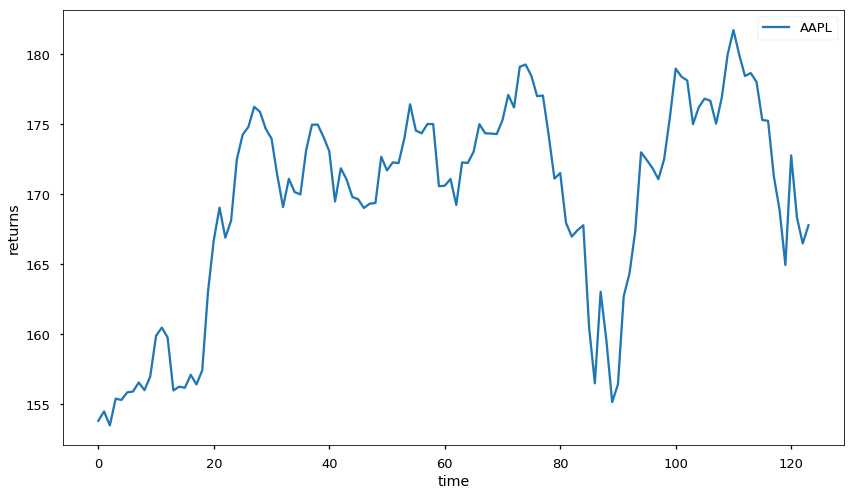

In [38]:
returns = dailyApplReturns
fig, ax = plt.subplots(figsize=(14, 8))
ax.plot(returns, label='AAPL')
ax.set(xlabel='time', ylabel='returns')
ax.legend();

In [39]:
with pm.Model() as model:
    step_size = pm.Exponential('sigma', 50.)
    s = GaussianRandomWalk('s', sd=step_size,
                           shape=len(returns))

    nu = pm.Exponential('nu', .1)

    r = pm.StudentT('r', nu=nu,
                    lam=pm.math.exp(-2*s),
                    observed=returns)

In [40]:
with model:
    trace = pm.sample(tune=2000, nuts_kwargs=dict(target_accept=.9))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu_log__, s, sigma_log__]
100%|██████████| 2500/2500 [03:24<00:00, 12.24it/s]
The acceptance probability does not match the target. It is 0.6587427090541224, but should be close to 0.9. Try to increase the number of tuning steps.
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


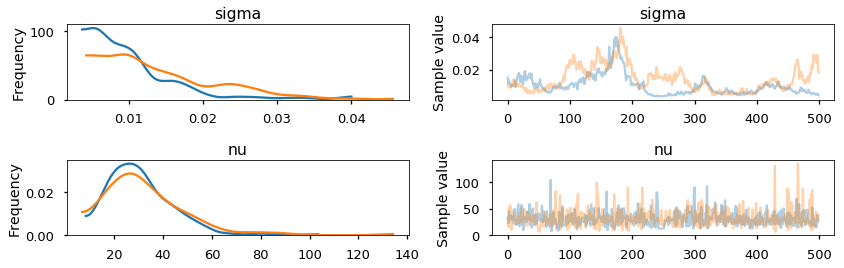

In [41]:
pm.traceplot(trace, varnames=['sigma', 'nu']);

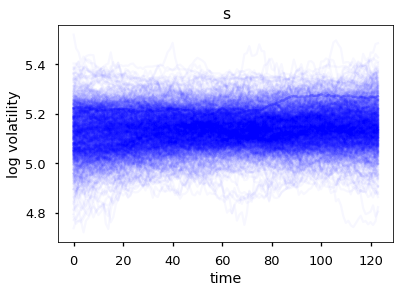

In [42]:
fig, ax = plt.subplots()

plt.plot(trace['s'].T, 'b', alpha=.03);
ax.set(title=str(s), xlabel='time', ylabel='log volatility');


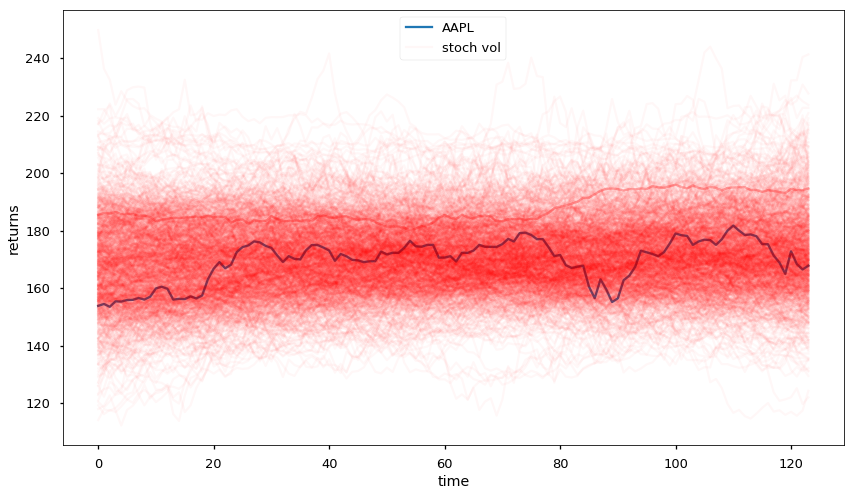

In [43]:
fig, ax = plt.subplots(figsize=(14, 8))
ax.plot(returns)
ax.plot(np.exp(trace[s].T), 'r', alpha=.03);
ax.set(xlabel='time', ylabel='returns')
ax.legend(['AAPL', 'stoch vol']);

In [44]:
#Let's try some gps
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import Matern, RBF


#Let's try it with jan, feb as train and march as test
X_train = pd.concat([ratingsJanuary, ratingsFebruary])
y_train = pd.concat([resultsJanuary, resultsFebruary])

X_test = ratingsMarch
y_test = resultsMarch


GP_RBF = GaussianProcessClassifier(kernel = 1.0 * RBF(length_scale=1.0))
GP_Matern = GaussianProcessClassifier(kernel = Matern(length_scale=2, nu=3/2))


GP_RBF.fit(X_train, y_train)
GP_Matern.fit(X_train, y_train)

##Uncomment this if you want to do basic predictions
#RBF_Test = accuracy_score(y_test, GP_RBF.predict(X_test))
#Matern_Test = accuracy_score(y_test, GP_Matern.predict(X_test))

##Using cross-val predictions
RBF_preds = cross_val_predict(GP_RBF, X_test, y_test, cv=n_folds)
RBF_Test = accuracy_score(y_test, RBF_preds)

Matern_preds = cross_val_predict(GP_Matern, X_test, y_test, cv=n_folds)
Matern_Test = accuracy_score(y_test, Matern_preds)

print("RBF_TEST: %.3f" %RBF_Test)
print("Matern_TEST: %.3f" %Matern_Test)

RBF_TEST: 0.567
Matern_TEST: 0.567


In [45]:
print("Log Marginal Likelihood (GP_RBF): %.3f"
      % GP_RBF.log_marginal_likelihood(GP_RBF.kernel_.theta))
print("Log Marginal Likelihood (GP_Matern): %.3f"
      % GP_Matern.log_marginal_likelihood(GP_Matern.kernel_.theta))

Log Marginal Likelihood (GP_RBF): -41.275
Log Marginal Likelihood (GP_Matern): -42.324


In [46]:
#Let's see how it performs using 10-fold cross validation on all the data

X_train = pd.concat([X_train, ratingsMarch])
y_train = pd.concat([y_train, resultsMarch])

GP_RBF.fit(X_train, y_train)
GP_Matern.fit(X_train, y_train)

RBF_Test = accuracy_score(y_test, GP_RBF.predict(X_test))
Matern_Test = accuracy_score(y_test, GP_Matern.predict(X_test))

RBF_Scores = cross_val_score(GP_RBF, X_train, y_train, cv=n_folds)
RBF_Scores


array([0.55555556, 0.55555556, 0.55555556, 0.55555556, 0.55555556,
       0.55555556, 0.33333333, 0.55555556, 0.22222222, 0.55555556])

In [47]:
Matern_Scores = cross_val_score(GP_Matern, X_train, y_train, cv=n_folds)
Matern_Scores

/home/retsim/.local/lib/python2.7/site-packages/sklearn/gaussian_process/gpc.py:430: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([1.28658449e-05]), 'nit': 8, 'funcalls': 52}
  " state: %s" % convergence_dict)


array([0.55555556, 0.55555556, 0.55555556, 0.55555556, 0.55555556,
       0.55555556, 0.55555556, 0.55555556, 0.22222222, 0.55555556])

In [48]:
X_train = pd.concat([ratingsJanuary, ratingsFebruary])
y_train = pd.concat([resultsJanuary, resultsFebruary])

X_test = ratingsMarch
y_test = resultsMarch

GP_RBF.fit(X_train, y_train)
GP_Matern.fit(X_train, y_train)

sigma_RBF = GP_RBF.predict_proba(X_test)
sigma_RBF = sigma_RBF[:,1]
y_pred_RBF = GP_RBF.predict(X_test)

sigma_Matern = GP_Matern.predict_proba(X_test)
sigma_Matern = sigma_Matern[:,1]
y_pred_Matern = GP_Matern.predict(X_test)

In [49]:
sigma_RBF.view()

array([0.61693785, 0.5       , 0.5       , 0.4330351 , 0.56696489,
       0.38306214, 0.4330351 , 0.56696489, 0.4330351 , 0.5       ,
       0.5       , 0.5       , 0.5       , 0.38306214, 0.5       ,
       0.5       , 0.61693785, 0.5       , 0.56696489, 0.4330351 ,
       0.5       , 0.4330351 , 0.38306214, 0.5       , 0.5       ,
       0.38306214, 0.61693785, 0.4330351 , 0.5       , 0.5       ])

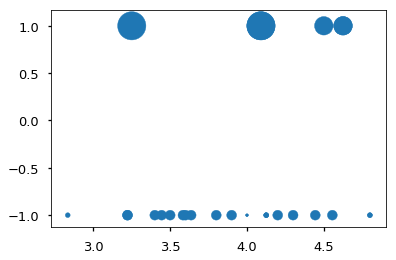

In [50]:
#Here's a plot of the rbf results, where size of marker indicates higher confidence
s = [100000*sigma**10 for sigma in sigma_RBF]
plt.scatter(X_test, y_pred_RBF, s=s)

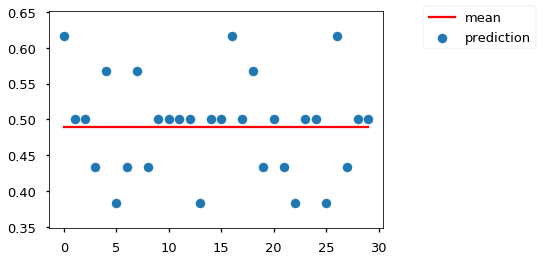

In [51]:
plt.scatter(np.arange(30),sigma_RBF, label = 'prediction')
plt.plot(np.arange(30), np.full((30,),sigma_RBF.mean()), color = 'red', label='mean')
plt.legend(bbox_to_anchor=(1.1, 1.05))

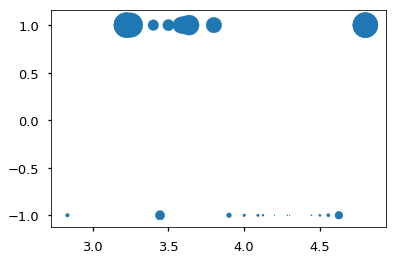

In [52]:
#Let's do the same thing for Matern kernel
s = [100000*sigma**10 for sigma in sigma_Matern]
plt.scatter(X_test, y_pred_Matern, s=s)

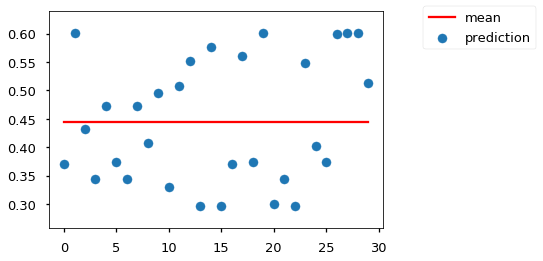

In [53]:
plt.scatter(np.arange(30),sigma_Matern, label = 'prediction')
plt.plot(np.arange(30), np.full((30,),sigma_Matern.mean()), color = 'red', label='mean')
plt.legend(bbox_to_anchor=(1.1, 1.05))